In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
         
        self.conv1 = nn.Conv2d(3, 10, kernel_size=101, stride=1, padding=0)
        self.conv2 = nn.Conv2d(10, 35, kernel_size=101, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=5)
         
        self.conv3 = nn.Conv2d(35, 100, kernel_size=6, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(2 * 2 * 100, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)  
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        print(x.shape)
        x = self.relu(self.conv1(x))   
        print(x.shape)
        x = self.relu(self.conv2(x))   
        print(x.shape)
        x = self.pool1(x)             
        print(x.shape)
        x = self.relu(self.conv3(x))  
        print(x.shape)
        x = self.pool2(x)             
        print(x.shape)
        x = x.view(x.size(0), -1)      
        x = self.relu(self.fc1(x))    
        x = self.relu(self.fc2(x))    
        x = self.fc3(x)               
        return x
 
batch_size = 64
epochs = 10
learning_rate = 0.001
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
transform = transforms.Compose([
    transforms.Resize((250, 250)),   
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
 
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
        break
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
    break

# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = 100 * correct / total
# print(f'Accuracy on test set: {accuracy:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 250, 250])
torch.Size([64, 10, 150, 150])
torch.Size([64, 35, 50, 50])
torch.Size([64, 35, 10, 10])
torch.Size([64, 100, 5, 5])
torch.Size([64, 100, 2, 2])
Epoch [1/10], Average Loss: 0.0059


In [31]:
models??

Type:        module
String form: <module 'torchvision.models' from 'C:\\Users\\22bad052\\AppData\\Roaming\\Python\\Python310\\site-packages\\torchvision\\models\\__init__.py'>
File:        c:\users\22bad052\appdata\roaming\python\python310\site-packages\torchvision\models\__init__.py
Source:     
from .alexnet import *
from .convnext import *
from .densenet import *
from .efficientnet import *
from .googlenet import *
from .inception import *
from .mnasnet import *
from .mobilenet import *
from .regnet import *
from .resnet import *
from .shufflenetv2 import *
from .squeezenet import *
from .vgg import *
from .vision_transformer import *
from .swin_transformer import *
from .maxvit import *
from . import detection, optical_flow, quantization, segmentation, video

# The Weights and WeightsEnum are developer-facing utils that we make public for
# downstream libs like torchgeo https://github.com/pytorch/vision/issues/7094
# TODO: we could / should document them publicly, but it's not clea

In [25]:
import torch
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()  

efficientnet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
efficientnet.eval() 

transform = transforms.Compose([
    transforms.Resize(256),            
    transforms.CenterCrop(224),       
    transforms.ToTensor(),             
    transforms.Normalize(              
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = json.loads(response.content)  

def load_image(image_path):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    return image

def predict_resnet(image):
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = resnet(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return labels[predicted.item()]
 
def predict_efficientnet(image):
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = efficientnet(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return labels[predicted.item()]
 
image_path = 'https://img.freepik.com/premium-photo/colorful-dog-cat-ferret-rabbit-bird-fish-rodent-animals-isolated-white-background_94628-20830.jpg'
image = load_image(image_path)

resnet_pred = predict_resnet(image)
efficientnet_pred = predict_efficientnet(image)

print(f"ResNet50 Prediction: {resnet_pred}")
print(f"EfficientNet-B0 Prediction: {efficientnet_pred}")

Loaded pretrained weights for efficientnet-b0
ResNet50 Prediction: Golden Retriever
EfficientNet-B0 Prediction: Golden Retriever


In [26]:
import torch
from PIL import Image
import requests
from io import BytesIO
 
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
 
def load_image(image_path):
    if image_path.startswith('http'):  
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:   
        image = Image.open(image_path)
    return image
 
image_path = 'https://img.freepik.com/premium-photo/colorful-dog-cat-ferret-rabbit-bird-fish-rodent-animals-isolated-white-background_94628-20830.jpg'  
image = load_image(image_path)
 
results = yolo_model(image)
# results.print()
# results.show()
# results.save()

Using cache found in C:\Users\22bad052/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-3-20 Python-3.10.7 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\22bad052/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [29]:
results.print()

image 1/1: 393x626 2 birds, 3 cats, 2 dogs
Speed: 0.0ms pre-process, 77.3ms inference, 0.0ms NMS per image at shape (1, 3, 416, 640)


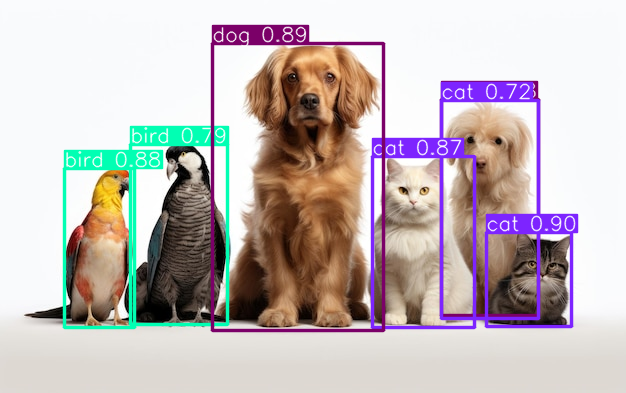

In [30]:
results.show()